<h1>Прогноз оттока клиентов банка</h1>

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нам нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.
Необходимо построить модель с предельно большим значением F1-меры. 

F1-мера не должна быть меньше 0.59.

**Описание данных:**

*Признаки:*

    RowNumber — индекс строки в данных
    CustomerId — уникальный идентификатор клиента
    Surname — фамилия
    CreditScore — кредитный рейтинг
    Geography — страна проживания
    Gender — пол
    Age — возраст
    Tenure — количество недвижимости у клиента
    Balance — баланс на счёте
    NumOfProducts — количество продуктов банка, используемых клиентом
    HasCrCard — наличие кредитной карты
    IsActiveMember — активность клиента
    EstimatedSalary — предполагаемая зарплата

*Целевой признак:*

    Exited — факт ухода клиента

**План работы**: первым делом мы познакомимся с нашими данными и сделаем первые выводы по ним, далее - предобработаем их, затем - наша работа поделится на два больших этапа: работа с моделями, в которых не учитывается дисбаланс классов, и с моделями, в которых учитывается, по каждому из этих двух блоков мы будем считать метрики качества, анализировать их, для второго раздела мы также опробуем различные наборы обучающих данных - для минимизации эффекта дисбаланса классов, в завершении работы - мы протестируем лучшую модель на тестовой выборке и сделаем выводы. 

<h3>Оглавление</h3>

1. [Шаг 1: Знакомство с данными](#start)
2. [Шаг 2: Подготовка признаков и деление на выборки](#preproc)
3. [Шаг 3: Построение моделей без учета дисбаланса классов](#notbalanced)
4. [Шаг 4: Построение моделей с учетом дисбаланса классов](#balanced)
5. [Шаг 5: Сравнение получившихся моделей](#compare)
6. [Шаг 6: Финальное тестирование модели](#test)

<h3>Шаг 1: Знакомство с данными</h3>
<a id='start'></a>

Первым делом - импортируем необходимые нам библиотеки.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import warnings
from sklearn.utils import shuffle 

Следом - наш датасет. Посмотрим на первые пять строк и на общую информацию о датафрейме.

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


На основании увиденного можно сделать выводы по данному шагу (и завершить его).

**Выводы по Шагу 1:** итак, мы ознакомились с данными, наш датасет содержит в себе 10 тысяч строк, это хорошая новость, данные выглядят весьма адекватно, пропуски присутствуют только в одном столбце - с недвижимостью, бросается в глаза факт того, что тип некоторых нужных нам столбцов - object - т.е. переменные категориальные, это мы исправим на следующем Шаге. 

<h3>Шаг 2: Подготовка признаков и деление на выборки</h3>
<a id='preproc'></a>

На данном Шаге мы подготовим наши признаки, а также - поделим данные на выборки.

На прошлом Шаге мы изучили наш датасет, очевидно - не все столбцы в нем пригодны для использования в качестве признаков. Для удобства дальнейшей работы мы их удалим. Это следующие поля: RowNumber, CustomerId, Surname. 

In [5]:
data = data.drop(columns = ['RowNumber', 'CustomerId', 'Surname'])

**Исследование признаков на предмет аномалий**

Для предыдущем шаге мы выявили явную проблему - пропуски. Будем помнить про нее и разберемся позже. А пока - посмотрим как обстоят дела с остальными признаками: построим графики, посчитаем статистики. Это необходимо сделать, чтобы убедиться в отсутствии неявных пропусков и выбросов. 

Начнем с CreditScore.

In [6]:
data['CreditScore'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64

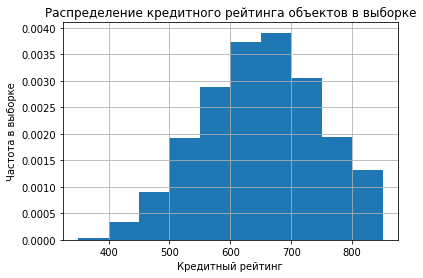

In [7]:
data['CreditScore'].plot(kind='hist', grid=True, density=True)
plt.xlabel('Кредитный рейтинг')
plt.ylabel('Частота в выборке')
plt.title('Распределение кредитного рейтинга объектов в выборке')
plt.show()

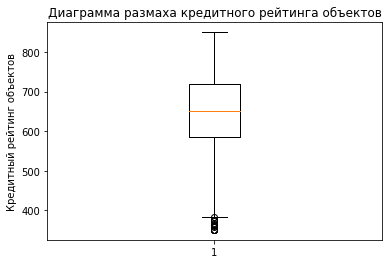

In [8]:
plt.boxplot(data['CreditScore'])
plt.ylabel('Кредитный рейтинг объектов')
plt.title('Диаграмма размаха кредитного рейтинга объектов')
plt.show()

Какие выводы можно сделать по этому полю? Ну, диаграмма размаха сообщает нам о том, что есть выбросы, но взглянув на гистограмму - можно от этой мысли отказаться: распределение нормальное, значения, значительно отличающиеся от мат. ожидания, этому распределению вполне соответствуют. 

Посмотрим на Geography. Признак не количественный, посмотрим на значения в столбце и их количества.

In [9]:
data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Всего три страны, Франция слегка перевешивает. Ничего сверхъестественного, двигаемся дальше.

Аналогично посмотрим на Gender.

In [10]:
data['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

Все прекрасно. Перейдем к более интересному - к возрасту.

In [11]:
data['Age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: Age, dtype: float64

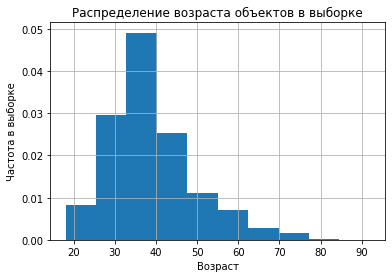

In [12]:
data['Age'].plot(kind='hist', grid=True, density=True)
plt.xlabel('Возраст')
plt.ylabel('Частота в выборке')
plt.title('Распределение возраста объектов в выборке')
plt.show()

Распределение признака нормальное, на гистограмме длинный 'хвост' справа, но это объясняется семантикой признака - люди любых возрастов могут пользоваться услугами банка. Человека, которому 500 лет, в выборке нет и ладно. 

Следующий - Balance.

In [13]:
data['Balance'].describe()

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: Balance, dtype: float64

In [14]:
'В выборке {:.2%} людей с нулем на балансе'.format(data[data['Balance'] == 0].shape[0] / data.shape[0])

'В выборке 36.17% людей с нулем на балансе'

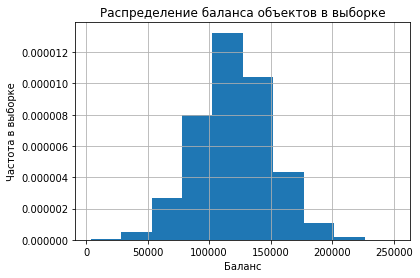

In [15]:
data[data['Balance'] != 0]['Balance'].plot(kind='hist', grid=True, density=True)
plt.xlabel('Баланс')
plt.ylabel('Частота в выборке')
plt.title('Распределение баланса объектов в выборке')
plt.show()

Итак, у нас больше трети выборки имеет ноль на счету, остальные значения распределены нормально. Ничего подозрительного. Перейдем к NumOfProducts.

In [16]:
data['NumOfProducts'].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

Все в порядке.

Теперь HasCrCard и IsActiveMember. Тут же проверим, нет ли чего лишнего в столбце с целевым признаком.

In [17]:
data['HasCrCard'].value_counts()

1    7055
0    2945
Name: HasCrCard, dtype: int64

In [18]:
data['IsActiveMember'].value_counts()

1    5151
0    4849
Name: IsActiveMember, dtype: int64

In [19]:
data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Обратим здесь внимание на результаты рассмотрения целевого признака - элементов одного класса в четыре раза меньше, чем другого. Наблюдается явный дисбаланс классов. Учтем его на определенной стадии нашей работы.

И последний столбец - с предполагаемой зарплатой (с Tenure мы будем работать отдельно).

In [20]:
data['EstimatedSalary'].describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: EstimatedSalary, dtype: float64

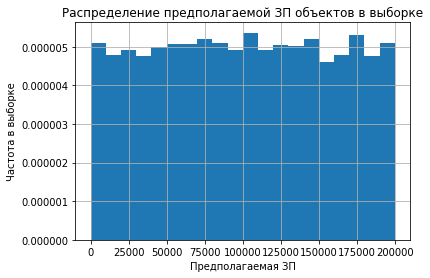

In [21]:
data['EstimatedSalary'].plot(kind='hist', grid=True, density=True, bins=20)
plt.xlabel('Предполагаемая ЗП')
plt.ylabel('Частота в выборке')
plt.title('Распределение предполагаемой ЗП объектов в выборке')
plt.show()

Интересно - распределение равномерное. Явные аномалии отсутствуют.

*Промежуточный вывод:* наши признаки выглядят хорошо, для обучениия модели их придется лишь слегка подготовить.

**One Hot Encoding**

Теперь решим вопрос с категориальными признаками.

Посмотрим, сколько признаков у нас являются категориальными. 

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Такие признаки: Geography, Gender. Типы данных столбцов - object. Воспользуемся кодированием, чтобы преобразовать категориальные признаки. 

In [23]:
data = pd.get_dummies(data, drop_first=True)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               9091 non-null float64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
Gender_Male          10000 non-null uint8
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


Получилось.

**Обработка пропусков**

Далее - нам следует разобраться с пропусками в столбце Tenure. Построим гистограмму для столбца, посчитаем среднее и медиану.

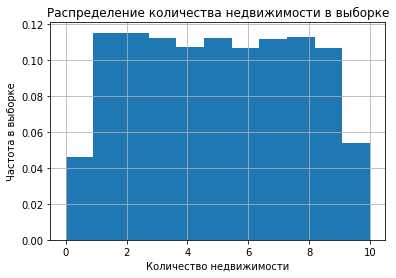

In [25]:
data['Tenure'].plot( kind = 'hist', bins =11, grid=True, density=True)
plt.xlabel('Количество недвижимости')
plt.ylabel('Частота в выборке')
plt.title('Распределение количества недвижимости в выборке')
plt.show()

In [26]:
data['Tenure'].median()

5.0

In [27]:
data['Tenure'].mean()

4.997690023099769

Что можно сказать? Если не брать во внимание крайние случаи - 0 и 10 недвижимости, то распределение признака - равномерное. Заполним пропуски медианой. Но перед этим - еще один момент.

Попробуем по-другому: в жизни количество недвижимости зависит от зарплаты по простому закону (часто) - чем выше ЗП, тем больше у тебя денег и недвижимости. Посмотрим на коэффициенты корелляции. Заодно просмотрим наши признаки на предмет мультиколлинеарности.

In [28]:
data.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
CreditScore,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,0.005538,0.004780,-0.002857
Age,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323,0.046897,-0.001685,-0.027544
Tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761,-0.003299,0.000810,0.012634
Balance,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533,0.401110,-0.134892,0.012087
NumOfProducts,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820,-0.010419,0.009039,-0.021859
HasCrCard,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,0.010577,-0.013480,0.005766
IsActiveMember,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,-0.020486,0.016732,0.022544
EstimatedSalary,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097,0.010297,-0.006482,-0.008112
Exited,-0.027094,0.285323,-0.016761,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000,0.173488,-0.052667,-0.106512
Geography_Germany,0.005538,0.046897,-0.003299,0.401110,-0.010419,0.010577,-0.020486,0.010297,0.173488,1.000000,-0.332084,-0.024628


Мимо. Оставлять пропуски плохая идея, удалить десятую часть столбца мы не можем. Вернемся к идее заполнения цифрой 5. 

In [29]:
data = data.fillna(5)

**Разбиение на выборки**

Пора разбить наш датафрейм на: 1)целевой признак и остальные признаки, 2)на обучающую, валидационную и тестовую выборки.

Делим раз.

In [30]:
target = data['Exited']
features = data.drop(columns = ['Exited'])

Делим два. Соотношение будет следующее - 6:2:2 как обучающая:валидационная:тестовая. 

In [31]:
feat_train, feat_validtest, target_train, target_validtest = train_test_split(features, target, test_size=0.4, 
                                                                             random_state=12345, stratify=target)

In [32]:
feat_valid, feat_test, target_valid, target_test = train_test_split(feat_validtest, target_validtest, test_size=0.5,
                                                                  random_state=12345, stratify=target_validtest)

*Промежуточный вывод*: получили 6 датафреймов: 

    feat_train и target_train - обучающая выборка
    feat_valid и target_valid - валидационная выборка
    feat_test и target_test - тестовая выборка

**Вывод по Шагу 2:** на данном Шаге мы проделали важный этап работы - во-первых, мы изучили наши признаки, в том числе - целевой, обнаружили отсутствие аномалий и явный дисбаланс классов, во-вторых, мы преобразовали категориальный признаки в числовые и избавились от пропусков - все это позволит нам построить нашу модель, в-третьих, мы разделили наши данные на выборки.

На этом моменте пути расходятся. Нам осталось данные стандартизировать, но выборки будут разные (для обучения и, следовательно, стандартизации) в случаях учета дисбаланса классов и неучета. Не будем пока что ничего учитывать. Сделаем вид, что в целевом признаке поровну элементов обоих типов.

<h3>Шаг 3: Построение моделей без учета дисбаланса классов</h3>
<a id='notbalanced'></a>

Итак, мы приступаем к построению модели без учета дисбаланса классов. Сценарий следующий: стандартизируем данные, обучим несколько моделей, посмотрим на их метрики качества и выберем лучшие.

**Стандартизация**

Как известно, разный масштаб данных может сыграть плохую шутку с моделью. Стандартизируем наши данные. 

In [33]:
scaler = StandardScaler()

Обучим стандартизатор и сразу применим его для трех выборок с признаками.

In [34]:
scaler.fit(feat_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [35]:
feat_train_1 = scaler.transform(feat_train)
feat_valid_1 = scaler.transform(feat_valid)
feat_test_1 = scaler.transform(feat_test)

Готово. Теперь модели.

**Обучение моделей и выбор лучших**

В данный работе рассмотрим: логистическую регрессию, случайный лес и метод k ближайших соседей. Для каждого алгоритма будем менять гиперпараметры (там, где это возможно, естественно) и искать лидера по метрике f1. Так, к концу подраздела должно быть 3 модели - лучшие среди других моделей - своих собратьев, обученных тем же алгоритмом. С этими тремя мы затем разберемся подробнее.

**Случайный лес**

Выберем лучший случайный лес. Подберем лучшую максимальную глубину - от 5 до 20 и лучшее количество деревьев - от 10 до 80 - с шагом 10. 

Мы напишем для этого функцию. Она нам еще не раз пригодится. 

Функция получает на вход значение гиперпараметра class_weight (пригодится в дальнейшем), обучающую выборку и валидационную (но без целевого признака, т.к. данный объект не будет меняться на протяжении всего процесса). Функция возращает лучшую модель и её значение метрики f1.

In [36]:
def bestRandomForest(class_w, feat_train, target_train, feat_valid):
    global target_valid
    best_f1 = 0
    best_depth = 0
    best_n = 0
    for i in range(5,21):
        for j in range(10,81,10):
            best_forest_1 = RandomForestClassifier(n_estimators=j, max_depth=i, random_state=12345, class_weight=class_w)
            best_forest_1.fit(feat_train, target_train)
            predicted = best_forest_1.predict(feat_valid)
            f1 = f1_score(target_valid, predicted)
            if f1>best_f1:
                best_f1 = f1
                best_depth = i
                best_n = j
    best_forest_1 = RandomForestClassifier(n_estimators=best_n, max_depth=best_depth, random_state=12345, class_weight=class_w)
    best_forest_1.fit(feat_train, target_train)
    return best_forest_1, best_f1

In [37]:
best_forest_1, best_f1 = bestRandomForest(None, feat_train_1, target_train, feat_valid_1)

Мы обнаружили лучший случайный лес. Посмотрим на его f1, значения гиперпараметров.

In [38]:
'F1 лучшего случайного леса: {:.2}'.format(best_f1)

'F1 лучшего случайного леса: 0.63'

In [39]:
best_forest_1

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

Количество деревьев - 60, максимальная глубина - 15. Теперь посчитаем и другие метрики: accuracy, recall, presicion, ROC-AUC, также - построим ROC-кривую.

Здесь мы напишем еще две функции - одну для ROC-кривой, вторую - для параметров.

In [40]:
def rocLine(model, feat_valid, name):
    global target_valid
    fpr, tpr, thresholds = roc_curve(target_valid, model.predict_proba(feat_valid)[:,1])
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая " + name)
    plt.show()

In [41]:
def metrics(model, feat_valid, name):
    global target_valid
    roc_auc = roc_auc_score(target_valid, model.predict_proba(feat_valid)[:,1])
    print('Roc-auc {}: {:.2}'.format(name, roc_auc))
    print('Accuracy {}: {:.2}'.format(name, accuracy_score(target_valid, model.predict(feat_valid))))
    print('Precision {}: {:.2}'.format(name, precision_score(target_valid, model.predict(feat_valid))))
    print('Recall {}: {:.2}'.format(name, recall_score(target_valid, model.predict(feat_valid))))

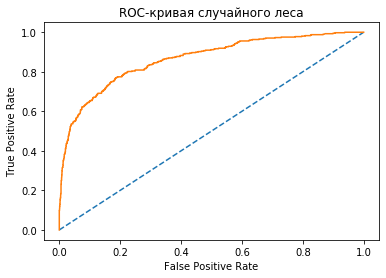

In [42]:
rocLine(best_forest_1, feat_valid_1, 'случайного леса')

In [43]:
metrics(best_forest_1, feat_valid_1, 'случайного леса')

Roc-auc случайного леса: 0.86
Accuracy случайного леса: 0.87
Precision случайного леса: 0.79
Recall случайного леса: 0.52


Сделаем некоторые выводы по полученным значениям.

Итак, у данной модели показатель f1 это 0.63, также мы увидели, что разница между полнотой и точностью почти 0.3 - если модель предсказывает единицу, то так оно и есть - чаще всего, но при этом, видит далеко не все принадлежности к положительному классу - только половину. При этом доля правильных ответов составляет - 0.87. Вспомним, что у нас дисбаланс классов - значений одного в 4 раза больше, то есть соотношение 4:1, если бы мы называли все наши объекты принадлежащими к большему классу, то получили бы accuracy  примерно 0.8, то есть выиграли у dummy-модели мы не сильно много. 

Наша ROC-кривая весьма высока, да и сам показатель ROC-AUC не мал - составляет 0.86, что выше показателя случайной модели на 0.36.

**Логистическая регрессия**

Займемся логистической регрессией.

In [44]:
best_log_1 = LogisticRegression(solver='liblinear', random_state=12345)
best_log_1.fit(feat_train_1, target_train)
predicted = best_log_1.predict(feat_valid_1)
'F1 логистической регрессии: {:.2}'.format(f1_score(target_valid, predicted))

'F1 логистической регрессии: 0.31'

Показатель в два раза ниже, чем у случайного леса. Посмотрим на остальные метрики, аналогично предыдущему подпункту - построим ROC-кривую.

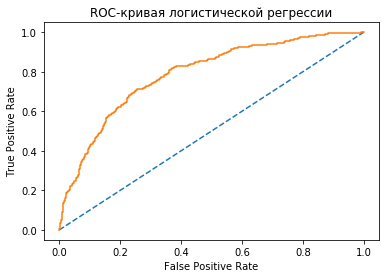

In [45]:
rocLine(best_log_1, feat_valid_1, 'логистической регрессии')

In [46]:
metrics(best_log_1, feat_valid_1, 'логистической регрессии')

Roc-auc логистической регрессии: 0.79
Accuracy логистической регрессии: 0.81
Precision логистической регрессии: 0.61
Recall логистической регрессии: 0.21


Посмотрим на ROC-кривую. Заметно, что она ниже, чем та, что построена для случайного леса. Roc-auc соответствует - тоже ниже, но выше, чем у случайной модели. Остальные метрики упали. Предыдущая модель была неважной, а эта еще хуже: доля правильных ответов совсем как у dummy-модели, полнота говорит о том, что модель классифицирует единицей только 20 процентов от объектов, действительно принадлежащих этому классу. Значение ключевой метрики f1 также не соотвествует требованиям. 

**Метод k ближайших соседей**

Теперь выберем лучшую модель, обученную алгоритмом k ближайших соседей. Переберем количество соседей от 3 до 15.

Аналогично случайному лесу - создадим функцию. Она возвращает лучшую модель и значение f1.

In [47]:
def bestKNN(feat_train, target_train, feat_valid):
    global target_valid
    best_f1 = 0
    best_k = 0
    for i in range(3,16):
        model = KNeighborsClassifier(n_neighbors=i)
        model.fit(feat_train, target_train)
        predicted = model.predict(feat_valid)
        f1 = f1_score(target_valid, predicted)
        if f1 > best_f1:
            best_f1 = f1
            best_k = i
    model = KNeighborsClassifier(n_neighbors=best_k)
    model.fit(feat_train, target_train)
    return model, best_f1

Мы обнаружили лучшую модель. Создадим ее, посмотрим на 'количество соседей' и f1.

In [48]:
best_knn_1, best_f1 = bestKNN(feat_train_1, target_train, feat_valid_1)
best_knn_1

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Получили оптимальное 'количество соседей' - 3.

In [49]:
'F1 лучшей knn-модели: {:.2}'.format(best_f1)

'F1 лучшей knn-модели: 0.5'

Теперь остальные метрики и ROC-кривая.

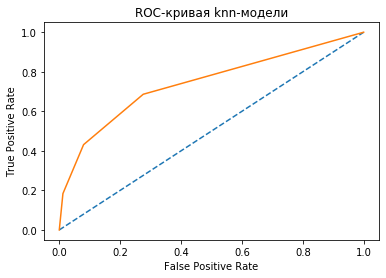

In [50]:
rocLine(best_knn_1, feat_valid_1, 'knn-модели')

In [51]:
metrics(best_knn_1, feat_valid_1, 'knn-модели')

Roc-auc knn-модели: 0.74
Accuracy knn-модели: 0.82
Precision knn-модели: 0.58
Recall knn-модели: 0.43


Обратим внимание на следующий момент: ROC-кривая для этой модели ниже, чем для логистической регрессии, roc-auc тоже ниже, то есть качество модели - хуже, но при этом она выдает лучшее f1.

Показатели этой модели лучше, чем у логистической регресии, но хуже, чем у случайного леса. Accuracy близка к доле правильных ответов dummy-модели, как и у логистической регрессии, зато - recall вырос в два раза, но все равно - различать лишь 43 процентов от объектов класса - мало.

**Вывод по Шагу 3**: итак, мы сделали определенный объем работы - а именно: стандартизировали данные, а затем - обучили несколько моделей, используя три алгоритма обучения: случайный лес, логистическую регрессию, метод k ближайших соседей. Мы не учитывали дисбаланс классов. По каждому алгоритму выбрали по лучшей модели, ни одну из них нельзя со спокойной совестью назвать качественной. Разве что, случайный лес подает надежды - у него f1 = 0.63 и доля правильных ответов лучше, чем у  dummy-модели. 

<h3>Шаг 4: Построение моделей с учетом дисбаланса классов</h3>
<a id='balanced'></a>

На данном Шаге мы опробуем три метода борьбы с дисбалансом классов: взвешивание классов, upsampling и downsampling. В рамках каждого метода отберем три лучших модели - по одной на алгоритм. Это все займет Этапы 1, 2, 3.

**Этап 1: Работа с лучшими моделями со взвешиванием классов**

*Случайный лес*

Аналогично предыдущему шагу - выберем лучший случайный лес, перебирая значение максимальной глубины от 5 до 20, а количества деревьев - от 10 до 80 с шагом 10. Классы взвешиваем.

In [52]:
best_forest_20, best_f1 = bestRandomForest('balanced', feat_train_1, target_train, feat_valid_1)

Нашли лучший случайный лес. Посмотрим на f1.

In [53]:
'F1 лучшего случайного леса, веса классов для которого взвешены: {:.2}'.format(best_f1)

'F1 лучшего случайного леса, веса классов для которого взвешены: 0.65'

Прогресс. Идем дальше, но перед этим - посмотрим на гиперпараметры.

In [54]:
best_forest_20

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=30, n_jobs=None, oob_score=False,
                       random_state=12345, verbose=0, warm_start=False)

Гиперпараметры отличаются от того леса, который получился без учета дисбаланса.

*Логистическая регрессия*

Посмотрим, что получится. Для осуществления метода взвешивания классов передаем гиперпараметру class_weight значение balanced.

In [55]:
best_log_20 = LogisticRegression(solver='liblinear', random_state=12345, class_weight='balanced')
best_log_20.fit(feat_train_1, target_train)
predicted = best_log_20.predict(feat_valid_1)
'F1 логистической регрессии, веса классов для которой взвешены: {:.2}'.format(f1_score(target_valid, predicted))

'F1 логистической регрессии, веса классов для которой взвешены: 0.53'

Значение метрики выросло. Было 0.31. Взвешивание классов помогло.

*Метод k ближайших соседей*

У моделей данного алгоритма нет такого параметра, поэтому оставим в качестве лучшей модели - выбранную на предыдущем шаге - с тремя соседями.

In [56]:
best_knn_20 = KNeighborsClassifier(n_neighbors=3)
best_knn_20.fit(feat_train_1, target_train)
'F1 лучшей knn-модели: {:.2}'.format(f1_score(target_valid, best_knn_20.predict(feat_valid_1)))

'F1 лучшей knn-модели: 0.5'

*Вывод по этапу*: здесь стоит отметить два момента, во-первых, данный метод оказался эффективен - f1 выросла для случайного леса и логистической регрессии, во-вторых, у случайного леса поменялись гиперпараметры - удивительно.

**Этап 2: Upsampling**

Мы опробовали взвешивание классов, сейчас будем использовать upsampling. Нам следует: поделить обучающую выборку ( не стандартизированную) на позитивные и негативные объекты, позитивных сделать в 4 раза больше, перемешать. Так мы получим новую обучающую выборку.

In [57]:
feat_zeros = feat_train[target_train == 0]
feat_ones = feat_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]
feat_train_21 = pd.concat([feat_zeros] + [feat_ones]*4)
target_train_21 = pd.concat([target_zeros] + [target_ones]*4)
feat_train_21, target_train_21 = shuffle(feat_train_21, target_train_21, random_state=12345)

Посмотрим на соотношения.

In [58]:
target_train_21.value_counts()

1    4888
0    4778
Name: Exited, dtype: int64

Хорошо получилось, и объем выборки большой. Теперь заново стандартизируем.

In [59]:
scaler21 = StandardScaler()
scaler21.fit(feat_train_21)
feat_train_21 = scaler21.transform(feat_train_21)
feat_valid_21 = scaler21.transform(feat_valid)
feat_test_21 = scaler21.transform(feat_test)

Можем обучать модели.

*Случайный лес*

Попробуем разную глубину и количество деревьев.

In [60]:
best_forest_21, best_f1 = bestRandomForest(None, feat_train_21, target_train_21, feat_valid_21)

Лучший вариант выбран. Посмотрим на гиперпараметры и f1.

In [61]:
best_forest_21 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [62]:
'F1 случайного леса, который обучался по увеличенной выборке: {:.2}'.format(best_f1)

'F1 случайного леса, который обучался по увеличенной выборке: 0.65'

Получили то же значение метрики, что и в предыдущем методе.

*Логистическая регрессия*

Обучим логистическую регрессию на увеличенной выборке.

In [86]:
best_log_21 = LogisticRegression(solver='liblinear', random_state=12345)
best_log_21.fit(feat_train_21, target_train_21)
predicted = best_log_21.predict(feat_valid_21)
'F1 логистической регрессии, которая обучена на увеличенной выборке: {:.2}'.format(f1_score(target_valid, predicted))

'F1 логистической регрессии, которая обучена на увеличенной выборке: 0.52'

Чуть хуже, чем в предыдущем методе.

*Метод k ближайших соседей*

Подберем оптимальное 'количество соседей', обучая модели на увеличенной выборке.

In [64]:
best_knn_21, best_f1 = bestKNN(feat_train_21, target_train_21, feat_valid_21)

Нашли. Посмотрим на гиперпараметры и f1.

In [65]:
best_knn_21

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

'Количество соседей' увеличилось.

In [66]:
'F1 лучшей модели, обученной по алгоритму k ближайших соседей и на увеличенной выборке: {:.2}'.format(best_f1)

'F1 лучшей модели, обученной по алгоритму k ближайших соседей и на увеличенной выборке: 0.5'

Результаты опечаливают: ничего не поменялось. 

*Вывод по этапу:* сравнивая с предыдущим методом мы имеем следующие результаты: у случайного леса и метода k ближайших соседей ничего не поменялось, у логистической регрессии прогресс на одну сотую, опять же - интересно наблюдать, гиперпараметры у моделей меняются от метода к методу.

**Этап 3: Downsampling**

Мы опробовали upsampling, сейчас приступаем к противоположному в каком-то смысле методу - к downsampling. Нам следует поделить обучающую выборку на позитивные и негативные объекты (это уже сделано), затем - из негативных выделить ровно четверть, сложить в одну выборку позитивные и выделенные негативные и перемешать. 

In [67]:
feat_train_22 = pd.concat([feat_zeros.sample(frac=0.25, random_state=12345)] + [feat_ones])
target_train_22 = pd.concat([target_zeros.sample(frac=0.25, random_state=12345)] + [target_ones])
feat_train_22, target_train_22 = shuffle(feat_train_22, target_train_22, random_state=12345)

Посмотрим на соотношение.

In [68]:
target_train_22.value_counts()

1    1222
0    1194
Name: Exited, dtype: int64

Это нам подходит. Теперь стандартизируем.

In [69]:
scaler22 = StandardScaler()
scaler22.fit(feat_train_22)
feat_train_22 = scaler22.transform(feat_train_22)
feat_valid_22 = scaler22.transform(feat_valid)
feat_test_22 = scaler22.transform(feat_test)

Приступаем к обучению. Все аналогично предыдущему этапу. У нас поменялась только выборка.

*Случайный лес*

Поработаем со случайным лесом.

In [70]:
best_forest_22, best_f1 = bestRandomForest(None, feat_train_22, target_train_22, feat_valid_22)

Нашли лучший. Посмотрим на гиперпараметры и значение f1.

In [71]:
best_forest_22

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [72]:
'F1 случайного леса, который обучался на уменьшенной выборке: {:.2}'.format(best_f1)

'F1 случайного леса, который обучался на уменьшенной выборке: 0.64'

Получился средний результат - лучше, чем без учета дисбаланса, и хуже, чем в двух предыдущих методах. Возможно, сказывается меньший размер обучающей выборки?

*Логистическая регрессия*

Теперь логистическая регрессия.

In [73]:
best_log_22 = LogisticRegression(solver='liblinear', random_state=12345)
best_log_22.fit(feat_train_22, target_train_22)
predicted = best_log_22.predict(feat_valid_22)
'F1 логистической регрессии, обученной на уменьшенной выборке: {:.2}'.format(f1_score(target_valid, predicted))

'F1 логистической регрессии, обученной на уменьшенной выборке: 0.53'

Получили такой же результат, что и во взвешивании, - лучший на данный момент по логистической регрессии.

*Метод k ближайших соседей*

Подберем лучшую модель, обученную алгоритмом k ближайших соседей.

In [74]:
best_knn_22, best_f1 = bestKNN(feat_train_22, target_train_22, feat_valid_22)

Посмотрим на гиперпараметры и метрику f1.

In [75]:
best_knn_22

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=14, p=2,
                     weights='uniform')

Сейчас соседей вообще 14.

In [76]:
'F1 модели, обученной алгоритмом k ближайших соседей на уменьшенной выборке: {:.2}'.format(best_f1)

'F1 модели, обученной алгоритмом k ближайших соседей на уменьшенной выборке: 0.55'

Только downsampling помог модели алгоритма k ближайших соседей. Впервые прогресс - теперь f1 даже лучше, чем у логистической регрессии.

*Вывод по этапу*: итак, на данном этапе мы опробовали downsampling, не получили ничего сверхъестественного относительно случайного леса и логистической регрессии, а вот результаты по модели k ближайших соседей радуют - метод помог, f1 выросло.

**Выводы по Шагу 4**: итак, на данном шаге мы опробовали три метода борьбы с дисбалансом классов, в рамках каждого метода обнаружили по лидеру на алгоритм. В итоге - получили 9 лучших моделей. Все методы показали себя примерно одинаково, в результате экспериментов f1 моделей от каждого алгоритма улучшилось. 

<h3>Шаг 5: Сравнение получившихся моделей</h3>
<a id='compare'></a>

На данном этапе мы будем сравнивать 12 моделей: три с Шага 3 и девять с Шага 4. Да, некоторые из них очевидно непригодны, но все равно представляют интерес. Создадим датафрейм для наглядности сравнения.

In [77]:
models = pd.DataFrame(columns = ['model_name','method','model', 'valid_sample'], data = [
    ['RandomForest', 'W_Classes', best_forest_20, feat_valid_1],
    ['LogisticRegression', 'W_Classes',best_log_20, feat_valid_1],
    ['RandomForest', 'Upsampling', best_forest_21, feat_valid_21], 
    ['LogisticRegression', 'Upsampling', best_log_21, feat_valid_21], 
    ['KNN', 'Upsampling',best_knn_21, feat_valid_21], 
    ['RandomForest', 'Downsampling', best_forest_22,feat_valid_22],     
    ['LogisticRegression', 'Downsampling', best_log_22, feat_valid_22], 
    ['KNN', 'Downsampling', best_knn_22, feat_valid_22],
    ['RandomForest', 'No', best_forest_1, feat_valid_1],
    ['LogisticRegression', 'No',best_log_1, feat_valid_1],
    ['KNN','No', best_knn_1, feat_valid_1]])

In [78]:
def f1(row):
    global target_valid
    return round(f1_score(target_valid, row['model'].predict(row['valid_sample'])),2)

def accuracy(row):
    global target_valid
    return round(accuracy_score(target_valid, row['model'].predict(row['valid_sample'])),2)

def precision(row):
    global target_valid
    return round(precision_score(target_valid, row['model'].predict(row['valid_sample'])),2)

def recall(row):
    global target_valid
    return round(recall_score(target_valid, row['model'].predict(row['valid_sample'])),2)

def roc_auc(row):
    global target_valid
    return round(roc_auc_score(target_valid, row['model'].predict_proba(row['valid_sample'])[:,1]),2)

Посчитаем для каждой модели f1, accuracy, precision, recall и roc_auc.

In [79]:
models['f1'] = models.apply(f1, axis=1)
models['accuracy'] = models.apply(accuracy, axis=1)
models['precision'] = models.apply(precision, axis=1)
models['recall'] = models.apply(recall, axis=1)
models['roc_auc'] = models.apply(roc_auc, axis=1)

Посмотрим, что получилось.

In [80]:
models[['model_name', 'method', 'f1', 'accuracy', 'precision', 'recall', 'roc_auc']]

,model_name,method,f1,accuracy,precision,recall,roc_auc
0,RandomForest,W_Classes,0.65,0.85,0.61,0.69,0.87
1,LogisticRegression,W_Classes,0.53,0.73,0.41,0.74,0.79
2,RandomForest,Upsampling,0.65,0.84,0.58,0.75,0.87
3,LogisticRegression,Upsampling,0.52,0.73,0.41,0.74,0.79
4,KNN,Upsampling,0.50,0.76,0.44,0.59,0.77
5,RandomForest,Downsampling,0.64,0.81,0.53,0.80,0.87
6,LogisticRegression,Downsampling,0.53,0.73,0.41,0.75,0.79
7,KNN,Downsampling,0.55,0.77,0.46,0.66,0.80
8,RandomForest,No,0.63,0.87,0.79,0.52,0.86
9,LogisticRegression,No,0.31,0.81,0.61,0.21,0.79


Сделаем некоторые выводы: 

*По методам*:

    - модели случайного леса лучше всего помогли методы: взвешивание классов и upsampling;
    - для модели логистической регрессии наиболее эффективен оказались методы: взвешивание классов и downsampling;
    - для модели алгоритма k ближайших соседей полезен оказался лишь метод downsampling;
    - несложно заметить, что каждый из этих методов эффективен - качество растет на всех моделях, просто где-то больше, а где-то меньше; 

*По моделям:*

    - наиболее удачной моделью является - случайный лес, даже не учитывая дисбаланс классов, мы получили f1-меру равную 0.63, а затем и 0.65; 
    - логистическая регрессия начала приближаться к качественной версии себя лишь после учета дисбаланса классов, лучший результат f1-меры по этому алгоритму равен 0.53; 
    - модель алгоритма k ближайших соседей вообще наиболее странный гость сегодня: модели не помог upsampling, зато с помошью downsampling'а мера f1 стала равной значению, которое выше, чем у лучшей логистической регрессии - получили 0.55; 
    - очевидно - выбирать финальную модель будем среди случайных лесов, обученных с учетом дисбаланса классов;

*По динамике метрик моделей*:

    - про связь roc-auc и f1: в 10 из 11 случаев мы имели с ростом f1 и рост roc-auc - площади под графиком ROC-кривой, что имеет свое объяснение, рост f1 говорит о том, что модель стала лучше, также и рост roc-auc сигнализирует о растущем качестве модели; но мы получили один случай, который выбивается из этого объяснения: на модели алгоритма k ближайших соседей, обученной без учета дисбалансов классов, у нас была f1-мера, равная 0.5 и roc-auc равный 0.74, а теперь для сравнения метрики еще одной модели: логистическая регрессия, обученная без учета дисбаланса классов: f1 = 0.31, roc-auc = 0.79, вопрос - как мы получили такую площадь под графиком ROC-кривой на логистической регрессии с такой f1-мерой? ответ: за таким низким f1 у нас скрывается низкое значение recall - модель более качественная, но она совсем не видит положительный класс - возможно, здесь следовало поменять порог классификации, тогда бы все встало на свои места; 
    - про разницу между значениями метрик моделей, обученных без учета дисбаланса классов, и значениями метрик остальных моделей: значение меры f1 для моделей, в которых применялись различные методы борьбы с дисбалансом классов, менялось в большую сторону: на немного или на много, либо не менялось вообще - а поисходило это все из-за роста полноты и (!) снижения точности, то есть - модели стали видеть больше объектов положительного класса, но вероятность того, что если класс назван положительным, то он такой и есть, упала; 
    - про accuracy: на Шаге 3 мы сравнивали значение данной метрики с accuracy dummy-модели - для случайного леса разница мер составляла 0.07, для остальных двух моделей - 0.02 и ниже; обратимся к моделям, на которых использовались downsampling и upsampling: для такого рода выборок - у случайной модели доля правильных ответов составляет 0.5, мы же получили значения от 0.73 до 0.84 - ощутимое отличие;

**Выводы по Шагу 5**: итак, на данном шаге мы сравнили 11 различных моделей, рассмотрели, как влияет на качество метод, который используется для борьбы с дисбалансом классов, как влияет выбранный алгоритм, как менялись метрики в ходе работы и выделили интересные факты о получившемся наборе значений метрик моделей. В результате проделанной работы мы можем выбрать лучшую модель - это случайный лес, обученный на выборке, составленной с помощью upsampling'a; у данной модели значение f1-меры - 0.65, что является лучшим результатом. 

<h3>Шаг 6: Финальное тестирование модели</h3>
<a id='test'></a>

Вспомним, в качестве лучшей модели была выбрана модель случайного леса, обученная на upsampled выборке. Осталось - провести тестирование модели на тестовой выборке. 

Посмотрим на значение f1-меры, а также на значения остальных метрик. 

In [81]:
'Значение метрики f1 на лучшей модели: {:.2}'.format(f1_score(target_test, best_forest_21.predict(feat_test_21)))

'Значение метрики f1 на лучшей модели: 0.6'

In [82]:
'Значение метрики recall на лучшей модели: {:.2}'.format(recall_score(target_test, best_forest_21.predict(feat_test_21)))

'Значение метрики recall на лучшей модели: 0.68'

In [83]:
'Значение метрики precision на лучшей модели: {:.2}'.format(precision_score(target_test, best_forest_21.predict(feat_test_21)))

'Значение метрики precision на лучшей модели: 0.54'

In [84]:
'Значение метрики accuracy на лучшей модели: {:.2}'.format(accuracy_score(target_test, best_forest_21.predict(feat_test_21)))

'Значение метрики accuracy на лучшей модели: 0.82'

In [85]:
'Значение метрики roc_auc на лучшей модели: {:.2}'.format(roc_auc_score(target_test, best_forest_21.predict(feat_test_21)))

'Значение метрики roc_auc на лучшей модели: 0.77'

**Вывод по Шагу 6**: итак, мы протестировали выбранную модель, получили не такие высокие показатели, как на валидационной выборке, но все равно - соответствующие требованиям задания и здравого смысла: f1 превышает значение 0.59, accuracy больше значения случайной модели. 